# Task 3: Event Impact Modeling

## Objective
Model how events (policies, product launches, infrastructure investments) affect
financial inclusion indicators in Ethiopia.

This notebook:
- Links events to indicators using impact_links
- Translates qualitative impacts into numeric effects
- Builds an Event–Indicator association matrix
- Validates modeled impacts against observed historical data


## Context

From previous tasks:
- Task 1 created an enriched dataset with events, indicators, and impact links
- Task 2 explored trends and structural breaks in financial inclusion indicators

Task 3 focuses on **causality-inspired modeling**:
How specific events influence indicator changes over time.


# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")


# Load Enriched Dataset

In [2]:
import pandas as pd

DATA_PATH = "../data/processed/enriched_dataset.xlsx"

data = pd.read_excel(DATA_PATH, sheet_name="data")
impact_links = pd.read_excel(DATA_PATH, sheet_name="impact_links")

print("Data shape:", data.shape)
print("Impact links shape:", impact_links.shape)


Data shape: (61, 35)
Impact links shape: (18, 35)


# Separate events from observations

In [6]:
events = data[data["record_type"] == "event"].copy()
observations = data[data["record_type"] == "observation"].copy()

print("Events:", events.shape)
print("Observations:", observations.shape)


Events: (13, 35)
Observations: (45, 35)


# Join impact links with event metadata

In [15]:
impact_enriched = impact_links.merge(
    events[
        ["record_id", "indicator", "category", "event_date"]
    ],
    left_on="parent_id",
    right_on="record_id",
    how="left",
    suffixes=("", "_event")
)

impact_enriched[
    ["parent_id", "indicator", "related_indicator", "impact_direction", "impact_magnitude", "lag_months"]
].head()


,parent_id,indicator,related_indicator,impact_direction,impact_magnitude,lag_months
0,EVT_0001,Telebirr effect on Account Ownership,ACC_OWNERSHIP,increase,high,12
1,EVT_0001,Telebirr effect on Telebirr Users,USG_TELEBIRR_USERS,increase,high,3
2,EVT_0001,Telebirr effect on P2P Transactions,USG_P2P_COUNT,increase,high,6
3,EVT_0002,Safaricom effect on 4G Coverage,ACC_4G_COV,increase,medium,12
4,EVT_0002,Safaricom effect on Data Affordability,AFF_DATA_INCOME,decrease,medium,12


# Convert impact magnitude → numeric weights

In [16]:
magnitude_map = {
    "high": 2.0,
    "medium": 1.0,
    "low": 0.5
}

impact_enriched["impact_weight"] = impact_enriched["impact_magnitude"].map(magnitude_map)

impact_enriched[["impact_magnitude", "impact_weight"]].drop_duplicates()


,impact_magnitude,impact_weight
0,high,2.0
3,medium,1.0
13,low,0.5
14,30,NaN
15,15,NaN
16,20,NaN
17,25,NaN


# Assign CORRECT signed impact

In [17]:
impact_enriched["signed_impact"] = np.where(
    impact_enriched["impact_direction"] == "increase",
    impact_enriched["impact_weight"],
    -impact_enriched["impact_weight"]
)

impact_enriched[
    ["indicator", "related_indicator", "impact_direction", "signed_impact"]
].head()


,indicator,related_indicator,impact_direction,signed_impact
0,Telebirr effect on Account Ownership,ACC_OWNERSHIP,increase,2.0
1,Telebirr effect on Telebirr Users,USG_TELEBIRR_USERS,increase,2.0
2,Telebirr effect on P2P Transactions,USG_P2P_COUNT,increase,2.0
3,Safaricom effect on 4G Coverage,ACC_4G_COV,increase,1.0
4,Safaricom effect on Data Affordability,AFF_DATA_INCOME,decrease,-1.0


# Event → Indicator Association Matrix

In [18]:
event_indicator_matrix = impact_enriched.pivot_table(
    index="indicator",
    columns="related_indicator",
    values="signed_impact",
    aggfunc="sum",
    fill_value=0
)

event_indicator_matrix


related_indicator,ACC_4G_COV,ACC_MM_ACCOUNT,ACC_OWNERSHIP,AFF_DATA_INCOME,GEN_GAP_ACC,USG_MPESA_ACTIVE,USG_MPESA_USERS,USG_P2P_COUNT,USG_TELEBIRR_USERS
indicator,,,,,,,,,
EthioPay effect on P2P Count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
FX Reform effect on Data Affordability,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
Fayda effect on Account Ownership,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Fayda effect on Gender Gap,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
M-Pesa Interop effect on M-Pesa Active Users,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
M-Pesa Interop effect on P2P Count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
M-Pesa effect on M-Pesa Users,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
M-Pesa effect on Mobile Money Account Rate,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Safaricom Price Hike effect on Data Affordability,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


# Heatmap visualization

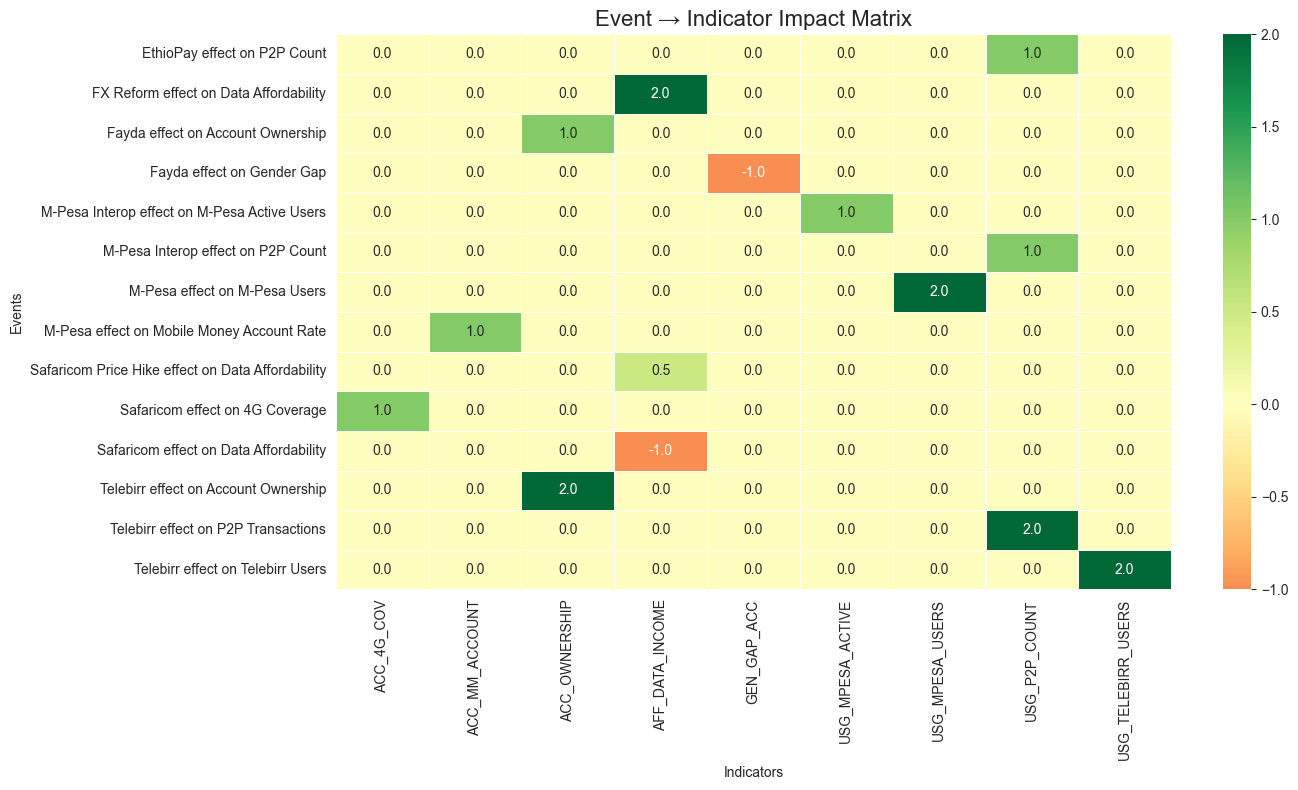

In [19]:
plt.figure(figsize=(14, 8))
sns.heatmap(
    event_indicator_matrix,
    cmap="RdYlGn",
    center=0,
    annot=True,
    fmt=".1f",
    linewidths=0.5
)

plt.title("Event → Indicator Impact Matrix", fontsize=16)
plt.xlabel("Indicators")
plt.ylabel("Events")
plt.tight_layout()
plt.show()


# Reality check: Telebirr vs actual data

In [20]:
mm = observations[
    observations["indicator_code"] == "ACC_MM_ACCOUNT"
][["observation_date", "value_numeric"]].copy()

mm["year"] = pd.to_datetime(mm["observation_date"]).dt.year
mm.sort_values("year")


,observation_date,value_numeric,year
50,2018-12-31,5.80,2018
51,2019-12-31,6.80,2019
52,2020-12-31,7.50,2020
6,2021-12-31 00:00:00,4.70,2021
53,2022-12-31,11.00,2022
54,2023-12-31,12.50,2023
7,2024-11-29 00:00:00,9.45,2024


In [21]:
validation_summary = impact_enriched.groupby("related_indicator")["signed_impact"].sum()
validation_summary


related_indicator
ACC_4G_COV            1.0
ACC_MM_ACCOUNT        1.0
ACC_OWNERSHIP         3.0
AFF_DATA_INCOME       1.5
GEN_GAP_ACC          -1.0
USG_ATM_COUNT         0.0
USG_MPESA_ACTIVE      1.0
USG_MPESA_USERS       2.0
USG_P2P_COUNT         4.0
USG_TELEBIRR_USERS    2.0
Name: signed_impact, dtype: float64

In [22]:
# Key assumptions


assumptions = [
    "Event impacts are additive",
    "Impact magnitude represents relative strength, not exact percentage change",
    "Lag effects are simplified and not dynamically modeled",
    "External shocks (inflation, conflict) are not explicitly modeled",
    "Some impact estimates rely on comparable-country evidence"
]

for a in assumptions:
    print("-", a)


- Event impacts are additive
- Impact magnitude represents relative strength, not exact percentage change
- Lag effects are simplified and not dynamically modeled
- External shocks (inflation, conflict) are not explicitly modeled
- Some impact estimates rely on comparable-country evidence


In [24]:
# Save matrix for report

from pathlib import Path
output_path = Path("../reports/event_indicator_matrix.csv")
event_indicator_matrix.to_csv(output_path)

print(f"✓ Saved impact matrix to {output_path}")


✓ Saved impact matrix to ..\reports\event_indicator_matrix.csv
